In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
from torch import nn #Dense layer

class CNN(nn.Module):
    def __init__(self, number_classes=10, input_size=28):

        super(CNN, self).__init__()
        self.number_classes = number_classes
        self.convolution_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), # First convolution layer
            nn.MaxPool2d(kernel_size=2, padding=0),

        )
        self.flatten = nn.Flatten()
        self.classifer_head = nn.Sequential(
            nn.Linear(32*13*13, 512), # first linear layer output// Dimension reduction   # We will try to parametrize the size
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.number_classes),
        )

    def forward(self, x):
        x = F.relu(self.convolution_block(x))
        x = self.flatten(x)
        
        
        logits = self.classifer_head(x)
        return logits  # class probabilites

In [3]:
model = CNN(number_classes=10)
print(model)
#model.convolution_block
#model.flatten
print(model.state_dict())

CNN(
  (convolution_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifer_head): Sequential(
    (0): Linear(in_features=5408, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
OrderedDict([('convolution_block.0.weight', tensor([[[[ 0.0136,  0.1667,  0.1302],
          [-0.3071, -0.2735,  0.0928],
          [-0.2439,  0.0482,  0.3123]]],


        [[[-0.2914,  0.0852,  0.2713],
          [ 0.2389, -0.1522, -0.1109],
          [ 0.3136, -0.1365,  0.1418]]],


        [[[ 0.2559,  0.2656, -0.3249],
          [-0.0070,  0.2095,  0.2049],
          [ 0.0715,  0.0324, -0.0374]]],


        [[[ 0.1961, -0.2685, -0.1683],
          [ 0.2141, -0.1019,  0.0681],
          [-0.2874,  0.0840

In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) 

In [5]:
loss_fn1 = nn.MSELoss()
loss_fn2 = nn.CrossEntropyLoss()

In [6]:
def train(dataloader, model, loss_fns, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader): # y : GT
        pred = model(X)
        loss_sum = 0
        for loss_fn in loss_fns:
          loss_sum += loss_fn(pred, y)

        optimizer.zero_grad()
        loss_sum.backward()
        optimizer.step()

        train_loss += loss_sum
        if batch % 1000 == 0:
            loss, current = loss_sum.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= len(dataloader)
    return train_loss

In [7]:
def test(dataloader, model, loss_fns):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # To freeze the network
        for X, y in dataloader:
            pred = model(X)
            test_loss_sum = 0
            for loss_fn in loss_fns:
                test_loss_sum += loss_fn(pred, y).item()
            test_loss += test_loss_sum
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # calculating number of batches

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [8]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.MNIST(root=".", train=True, download=True, transform=ToTensor())

test_data = datasets.MNIST(root=".", train=False, download=True, transform=ToTensor())

In [9]:
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

indices = torch.arange(0,1000)
training_data = data_utils.Subset(training_data, indices)

indices = torch.arange(0,100)
test_data = data_utils.Subset(test_data, indices)

BATCH_SIZE = 64

loaded_train = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
loaded_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
def eval_net(model, loss_fns, optimizer, num_epochs = 5):
    train_losses = []
    test_losses = []
    accuracy_scores = []

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(loaded_train, model, loss_fns, optimizer)
        train_loss = train_loss.detach().numpy()
        test_loss, accuracy = test(loaded_test, model, loss_fns)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracy_scores.append(accuracy)
    print("Done!")

    fig,axs = plt.subplots(1, 2, figsize=(8,8))
    axs = axs.ravel()
    axs[0].plot(range(num_epochs), train_losses, ":r")
    axs[0].plot(range(num_epochs), test_losses, "-b")

    axs[1].plot(range(num_epochs), accuracy_scores)

Epoch 1
-------------------------------
loss: 2.300711  [    0/ 1000]
Test Error: 
 Accuracy: 4.0%, Avg loss: 2.300613 

Epoch 2
-------------------------------
loss: 2.298596  [    0/ 1000]
Test Error: 
 Accuracy: 6.0%, Avg loss: 2.299557 

Epoch 3
-------------------------------
loss: 2.288218  [    0/ 1000]
Test Error: 
 Accuracy: 8.0%, Avg loss: 2.295080 

Epoch 4
-------------------------------
loss: 2.299695  [    0/ 1000]
Test Error: 
 Accuracy: 14.0%, Avg loss: 2.294585 

Epoch 5
-------------------------------
loss: 2.292181  [    0/ 1000]
Test Error: 
 Accuracy: 15.0%, Avg loss: 2.292421 

Epoch 6
-------------------------------
loss: 2.289809  [    0/ 1000]
Test Error: 
 Accuracy: 15.0%, Avg loss: 2.291731 

Epoch 7
-------------------------------
loss: 2.283859  [    0/ 1000]
Test Error: 
 Accuracy: 18.0%, Avg loss: 2.287825 

Epoch 8
-------------------------------
loss: 2.294212  [    0/ 1000]
Test Error: 
 Accuracy: 21.0%, Avg loss: 2.287778 

Epoch 9
-------------------

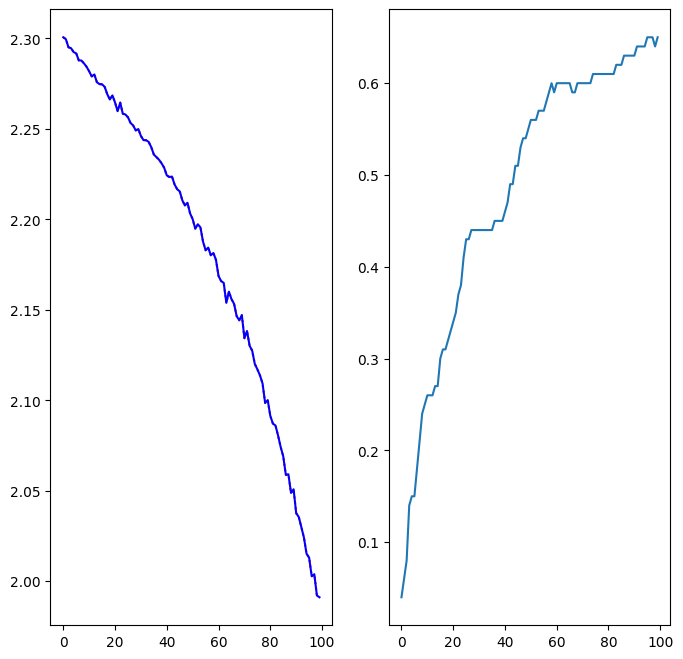

In [11]:
eval_net(model, loss_fns=[loss_fn2], optimizer=optimizer, num_epochs=100)